In [400]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.misc import imresize
from scipy.signal import convolve2d

In [475]:
# helper functions

def make_radius_map(Nx,Ny,dx,dy,x0,y0):
    yy,xx = np.meshgrid(np.arange(Nx),np.arange(Nx))
    rr = np.sqrt(((xx-x0)*dx)**2 + ((yy-y0)*dy)**2)
    return rr

def gauss2d(rr,dx,dy,sig):
    g = np.exp(-rr**2/2./sig**2) / (2*np.pi*sig**2)
    g *= dx*dy
    return g

def rebin_map_coarse(mapin,Nx,Ny):
    '''
    binning Nx,Ny mapin pixel to a large pixel.
    '''
    Nsx,Nsy = mapin.shape
    Nlx = round(Nsx/Nx)
    Nly = round(Nsy/Ny)
    
    rbmap=np.zeros([Nlx,Nly])
    for i in np.arange(Nlx):
        for j in np.arange(Nly):
            rbmap[i,j]=np.mean(mapin[i*Nx:(i+1)*Nx-1,j*Ny:(j+1)*Ny-1])

    return rbmap

def get_1D_profile(mapin,dx,dy, logbin=True, nbins = 15, binedges = []):
    rr = make_radius_map(mapin.shape[0],mapin.shape[1],dx,dy,Nsub,Nsub)
    rmin = min(rr[rr>0])
    rmax = max(rr[rr>0])

    if len(binedges)==0:
        if logbin: 
            binedges = np.logspace(np.log10(rmin),np.log10(rmax), nbins+1)
            bins = (binedges[:-1] + binedges[1:]) / 2
            binedges[0] = 0
            binedges[-1] *= 1.01
        else: 
            binedges = np.linspace(np.min(rmin), rmax, nbins+1)
            bins = np.sqrt(binedges[:-1] * binedges[1:])
            binedges[-1] *= 1.01

    else:
        bins = (binedges[:-1] + binedges[1:]) / 2
    
    P1D = np.histogram(rr, bins=binedges, weights=mapin)[0] \
         / np.histogram(rr, bins=binedges)[0]
    
    return P1D,bins

In [419]:
# define paramters

scale = 10 # subpixel is 'scale' times smaller than origial pixel
Npix = 5 # the stamp extend Npix pixels in each direction
Nsub = Npix*scale # stacking stamp: (Nsub*2+1)**2 subpixels
sig = 0.3 # w.r.t. large pixel
Nstack = 1000 # number of random source stacking

In [386]:
# true PSF

rr = make_radius_map(2*Nsub+1,2*Nsub+1,1./scale,1./scale,Nsub,Nsub)
psf_true = gauss2d(rr,1./scale,1./scale,sig)

In [384]:
# random position stacking

stack = np.zeros([2*Nsub+1,2*Nsub+1])
src_coord = np.random.uniform(Nsub-0.5, Nsub+scale-1+0.5,[Nstack,2])

for xsrc,ysrc in src_coord:
    rr = make_radius_map(2*Nsub+scale,2*Nsub+scale,1./scale,1./scale,xsrc,ysrc)
    psf = gauss2d(rr,1./scale,1./scale,sig)
    psf_coarse = rebin_map_coarse(psf,scale,scale)
    psf_fine=imresize(psf_coarse,float(scale),interp='nearest',mode='F')
    stamp = psf_fine[int(round(xsrc)-Nsub):int(round(xsrc)+Nsub+1),\
                     int(round(ysrc)-Nsub):int(round(ysrc)+Nsub+1)]
    stack += stamp/Nstack

In [489]:
# R-L deconvolution

w = np.zeros_like(stamp)
w[Nsub-scale//2:Nsub+scale//2+1,Nsub-scale//2:Nsub+scale//2+1]=1
w_mirror = w[::-1, ::-1]


u_t = stack
for iiter in np.arange(1):
    c = convolve2d(u_t,w,mode='same')
    r = np.zeros_like(c)
    r[c!=0] = stack[c!=0]/c[c!=0]
    r[c==0] = 0
    u_t1 = u_t * convolve2d (r , w_mirror, mode='same')
    u_t = u_t1
psf_1  = u_t


u_t = stack
for iiter in np.arange(10):
    c = convolve2d(u_t,w,mode='same')
    r = np.zeros_like(c)
    r[c!=0] = stack[c!=0]/c[c!=0]
    r[c==0] = 0
    u_t1 = u_t * convolve2d (r , w_mirror, mode='same')
    u_t = u_t1
psf_10  = u_t


u_t = stack
for iiter in np.arange(100):
    c = convolve2d(u_t,w,mode='same')
    r = np.zeros_like(c)
    r[c!=0] = stack[c!=0]/c[c!=0]
    r[c==0] = 0
    u_t1 = u_t * convolve2d (r , w_mirror, mode='same')
    u_t = u_t1
psf_100  = u_t

u_t = stack
for iiter in np.arange(1000):
    c = convolve2d(u_t,w,mode='same')
    r = np.zeros_like(c)
    r[c!=0] = stack[c!=0]/c[c!=0]
    r[c==0] = 0
    u_t1 = u_t * convolve2d (r , w_mirror, mode='same')
    u_t = u_t1
psf_1000  = u_t

Text(0.5,1,'RLD 1000 iter - True PSF')

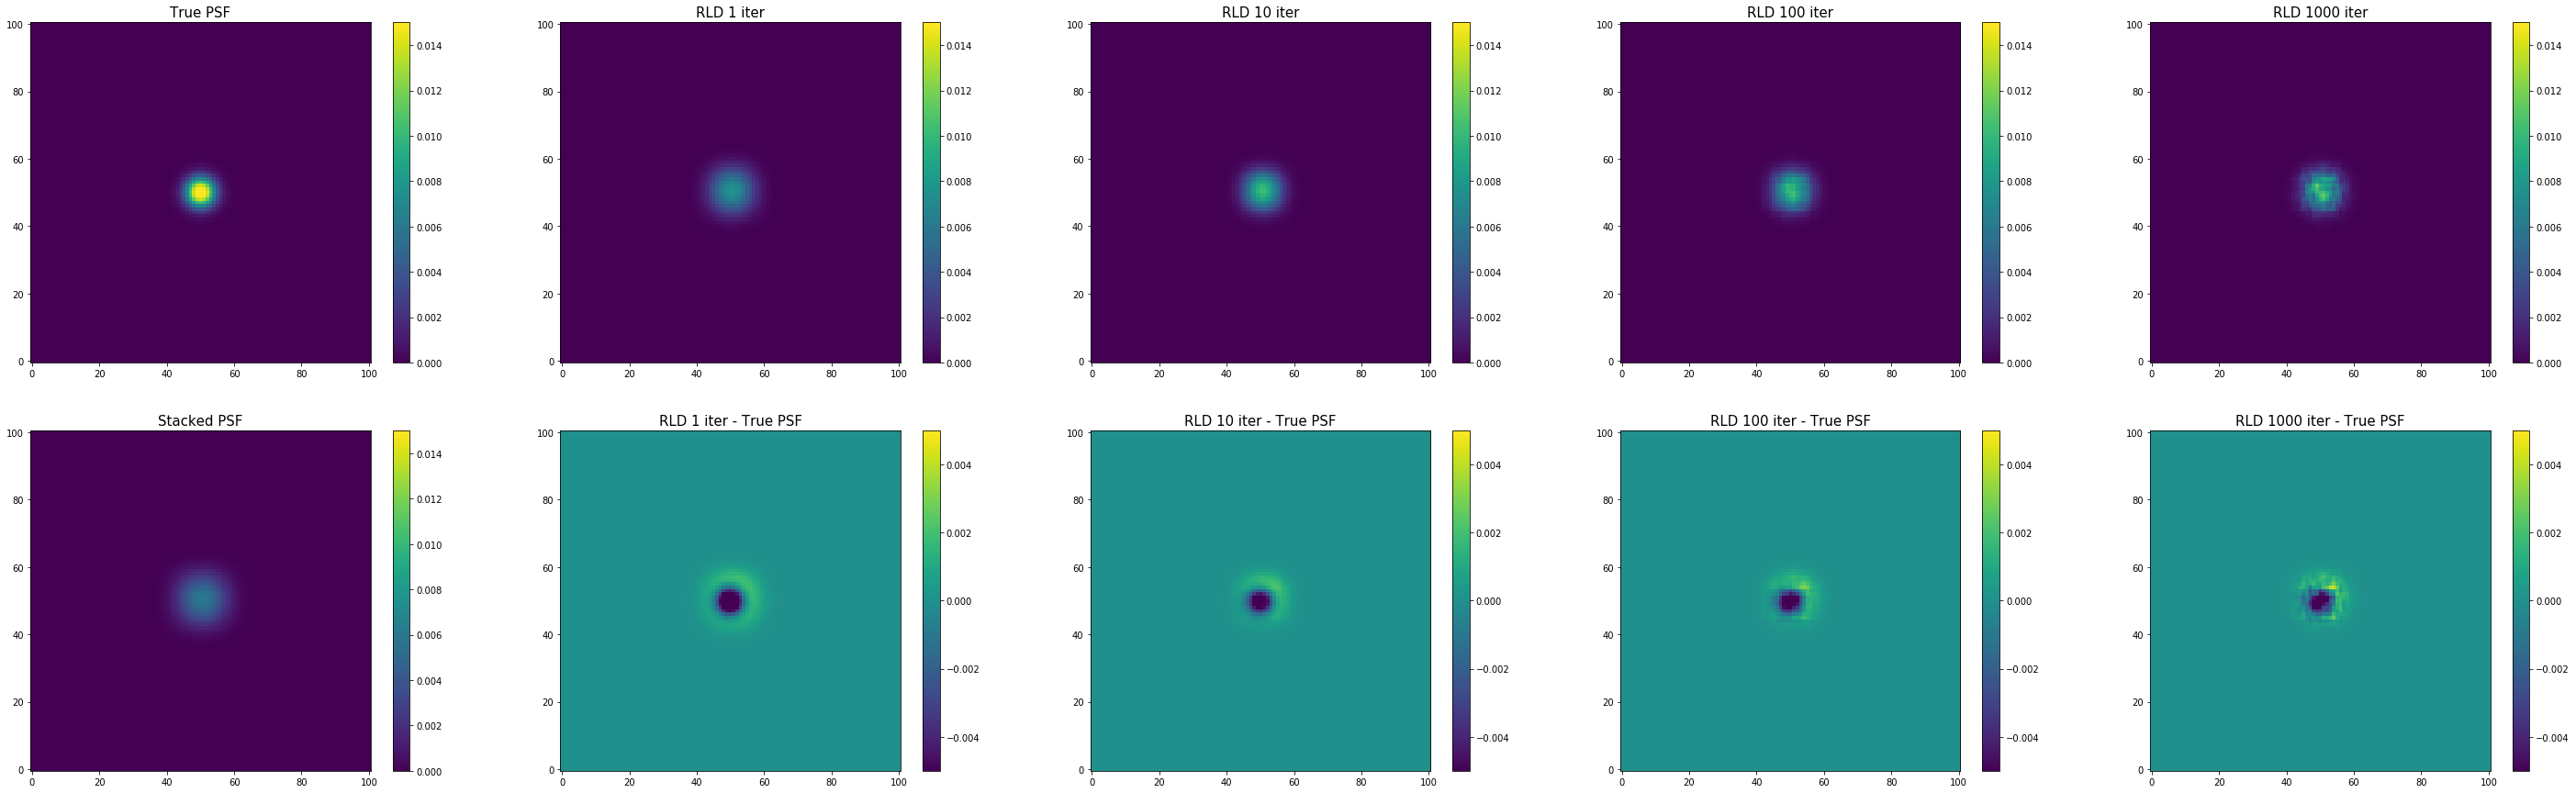

In [490]:
# plot the images

fig, ax = plt.subplots(2,5,figsize=(50,15))

im1 = ax[0][0].imshow(psf_true,origin='lower', vmin = 0, vmax = 0.015)
cb1 = plt.colorbar(im1, ax = ax[0][0])
ax[0][0].set_title('True PSF', fontsize = 15)

im1 = ax[1][0].imshow(stack,origin='lower', vmin = 0, vmax = 0.015)
cb1 = plt.colorbar(im1, ax = ax[1][0])
ax[1][0].set_title('Stacked PSF', fontsize = 15)

im1 = ax[0][1].imshow(psf_1,origin='lower', vmin = 0, vmax = 0.015)
cb1 = plt.colorbar(im1, ax = ax[0][1])
ax[0][1].set_title('RLD 1 iter', fontsize = 15)

im1 = ax[1][1].imshow(psf_1-psf_true,origin='lower', vmin = -0.005, vmax = 0.005)
cb1 = plt.colorbar(im1, ax = ax[1][1])
ax[1][1].set_title('RLD 1 iter - True PSF', fontsize = 15)

im1 = ax[0][2].imshow(psf_10,origin='lower', vmin = 0, vmax = 0.015)
cb1 = plt.colorbar(im1, ax = ax[0][2])
ax[0][2].set_title('RLD 10 iter', fontsize = 15)

im1 = ax[1][2].imshow(psf_10-psf_true,origin='lower', vmin = -0.005, vmax = 0.005)
cb1 = plt.colorbar(im1, ax = ax[1][2])
ax[1][2].set_title('RLD 10 iter - True PSF', fontsize = 15)

im1 = ax[0][3].imshow(psf_100,origin='lower', vmin = 0, vmax = 0.015)
cb1 = plt.colorbar(im1, ax = ax[0][3])
ax[0][3].set_title('RLD 100 iter', fontsize = 15)

im1 = ax[1][3].imshow(psf_100-psf_true,origin='lower', vmin = -0.005, vmax = 0.005)
cb1 = plt.colorbar(im1, ax = ax[1][3])
ax[1][3].set_title('RLD 100 iter - True PSF', fontsize = 15)

im1 = ax[0][4].imshow(psf_1000,origin='lower', vmin = 0, vmax = 0.015)
cb1 = plt.colorbar(im1, ax = ax[0][4])
ax[0][4].set_title('RLD 1000 iter', fontsize = 15)

im1 = ax[1][4].imshow(psf_1000-psf_true,origin='lower', vmin = -0.005, vmax = 0.005)
cb1 = plt.colorbar(im1, ax = ax[1][4])
ax[1][4].set_title('RLD 1000 iter - True PSF', fontsize = 15)

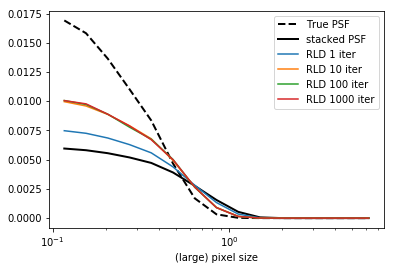

In [492]:
psf_true1D,bins = get_1D_profile(psf_true,1/scale,1/scale)
stack1D,bins = get_1D_profile(stack,1/scale,1/scale)
psf_11D,bins = get_1D_profile(psf_1,1/scale,1/scale)
psf_101D,bins = get_1D_profile(psf_10,1/scale,1/scale)
psf_1001D,bins = get_1D_profile(psf_100,1/scale,1/scale)
psf_10001D,bins = get_1D_profile(psf_1000,1/scale,1/scale)

plt.plot(bins,psf_true1D,'k--',lw=2,label='True PSF')
plt.plot(bins,stack1D,'k-',lw=2,label='stacked PSF')
plt.plot(bins,psf_11D,label='RLD 1 iter')
plt.plot(bins,psf_101D,label='RLD 10 iter')
plt.plot(bins,psf_1001D,label='RLD 100 iter')
plt.plot(bins,psf_10001D,label='RLD 1000 iter')
plt.xscale('log')
plt.xlabel('(large) pixel size')
plt.legend(loc=0)